<a href="https://colab.research.google.com/github/LotanLevy/DOC/blob/master/pinto_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow-gpu==2.3.0

In [84]:
# fmnist data
classes = 10
batchsize = 2

# MobileNetV2
size = 96
preprocessing_func = mobilenet_v2.preprocess_input

# VGG16
# size = 224
#preprocessing_func = vgg16.preprocess_input


# input_shape = (96, 96, 3)
# #input_shape = (224, 224, 3)


#feature_out = 4096 #secondary network out for VGG16
feature_out = 1280 #secondary network out for MobileNet
alpha = 0.5 #for MobileNetV2
lambda_ = 0.1 #for compact loss

In [131]:
class DataIter:
  def __init__(self, data, labels, batch_size, classes_num, shuffle=False, preprocess_func=lambda x:x):
    if labels is not None:
        assert(len(data) == len(labels))
        self.labels = np.array(labels)
    else:
      self.labels = None

    self.preprocess_func = preprocess_func

    self.data = data
    self.classes_num = classes_num
    self.batch_size = batch_size
    self.indices = np.arange(len(self.data)).astype(np.int)
    self.shuffle = shuffle
    self.on_epoch_end()

  def on_epoch_end(self):
      if self.shuffle:
        np.random.shuffle(self.indices)
      self.cur_idx = 0

  def next(self):
      relevant_indices = self.indices[self.cur_idx: self.cur_idx + self.batch_size]
      self.cur_idx += self.batch_size
      images = self.data[relevant_indices]
      if self.labels is not None:
        labels = self.labels[relevant_indices]
        labels = tf.keras.utils.to_categorical(labels, num_classes=self.classes_num)
      else:
        labels = None
      return self.preprocess_func(images), labels

  def get_all_data(self):
      return self.preprocess_func(self.data)


In [132]:
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import mobilenet_v2, vgg16

preprocessing_func = mobilenet_v2.preprocess_input

def mobilenet_v2_preprocessing(input_data):
  return input_data.astype('float32')/ 255


# dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32') 
# x_train = x_train / 255
# x_test = x_test / 255


# x_train = preprocessing_func(np.copy(x_train))
# x_test = preprocessing_func(np.copy(x_test))


#Learning data
x_train_s, x_test_s, x_test_b = [], [], []
x_ref, y_ref = [], []

x_train_shape = x_train.shape

for i in range(len(x_train)):
    if y_train[i] == 7: #Sneakers is 7
        temp = x_train[i]
        x_train_s.append(temp.reshape((x_train_shape[1:])))
    else:
        temp = x_train[i]
        x_ref.append(temp.reshape((x_train_shape[1:])))
        y_ref.append(y_train[i])

x_ref = np.array(x_ref)

#6000 randomly extracted from ref data
number = np.random.choice(np.arange(0,x_ref.shape[0]),6000,replace=False)

x, y = [], []

x_ref_shape = x_ref.shape

for i in number:
    temp = x_ref[i]
    x.append(temp.reshape((x_ref_shape[1:])))
    y.append(y_ref[i])

x_train_s = np.array(x_train_s)
x_ref = np.array(x)
y_ref = to_categorical(y)

train_s_loader = DataIter(np.array(x_train_s), None, batchsize, classes, shuffle=True, preprocess_func=mobilenet_v2_preprocessing)
ref_loader = DataIter(np.array(x), y, batchsize, classes, shuffle=True, preprocess_func=mobilenet_v2_preprocessing)



#test data
for i in range(len(x_test)):
    if y_test[i] == 7: #Sneakers is 7
        temp = x_test[i,:,:,:]
        x_test_s.append(temp.reshape((x_train_shape[1:])))

    if y_test[i] == 9: #Boots is 9
        temp = x_test[i,:,:,:]
        x_test_b.append(temp.reshape((x_train_shape[1:])))

test_s_loader = DataIter(np.array(x_test_s), None, batchsize, classes, preprocess_func=mobilenet_v2_preprocessing)
test_b_loader = DataIter(np.array(x_test_b), None, batchsize, classes, preprocess_func=mobilenet_v2_preprocessing)


x_test_s = test_s_loader.get_all_data()
x_test_b = test_b_loader.get_all_data()

In [133]:

import cv2
from PIL import Image

def resize(x, size=96):
    x_out = []

    for i in range(len(x)):
        img = cv2.cvtColor(x[i], cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img,dsize=(size,size))
        x_out.append(img)

    return np.array(x_out)

# X_train_s = resize(x_train_s)
# X_ref = resize(x_ref)
X_test_s = resize(x_test_s)
X_test_b = resize(x_test_b)

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.applications import mobilenet_v2, vgg16
#from tensorflow.keras.engine.network import Network




#Loss function
def original_loss(y_true, y_pred):
    n_dim = np.shape(y_pred)[0]  # number of features vecs
    k_dim = np.shape(y_pred)[1]  # feature vec dim
    print(n_dim,k_dim, classes*batchsize)

    lc = 1/(k_dim*n_dim)* n_dim**2 * K.sum((y_pred - K.mean(y_pred,axis=0))**2,axis=[1]) / ((n_dim-1)**2)
    return lc

#Learning
def train(x_target, x_ref, y_ref, epoch_num):

    #Read VGG16, S network
    print("Model build...")
    #mobile = tf.keras.applications.VGG16(include_top=True, input_shape=(size, size, 3), weights='imagenet')

    #Read mobile net, S network
    mobile = tf.keras.applications.MobileNetV2(include_top=True, input_shape=(size, size, 3), alpha=alpha, weights='imagenet')

    #Delete last layer
    # mobile.layers.pop()

    #Fixed weight
    for layer in mobile.layers:
        if layer.name == "block_13_expand": # "block5_conv1": for VGG16
            break
        else:
            layer.trainable = False

    model_t = Model(inputs=mobile.input,outputs=mobile.layers[-2].output)

    #Apply a Fully Connected Layer to R
    prediction = Dense(classes, activation='softmax')(model_t.output)
    model_r = Model(inputs=model_t.input,outputs=prediction)

    
    #Compile
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()

    optimizer = SGD(lr=5e-5, decay=0.00005)
    model_r.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=[train_accuracy])
    model_t.compile(optimizer=optimizer, loss=original_loss)


    model_t.summary()
    model_r.summary()

    print("x_target is",x_target.shape[0],'samples')
    print("x_ref is",x_ref.shape[0],'samples')

    ref_samples = np.arange(x_ref.shape[0])
    loss, loss_c, epoch_accuracy = [], [], []

    print("training...")

    #Learning
    for epochnumber in range(epoch_num):
        x_r, y_r, lc, ld, accuracy = [], [], [], [], []

        # #Shuffle target data
        # np.random.shuffle(x_target)

        #Shuffle reference data
        np.random.shuffle(ref_samples)
        for i in range(len(x_target)):
            x_r.append(x_ref[ref_samples[i]])
            y_r.append(y_ref[ref_samples[i]])
        x_r = np.array(x_r)
        y_r = np.array(y_r)

        for i in range(int(len(x_target) / batchsize)):
            #Load data for batch size

            batch_target, _ = train_s_loader.next()
            batch_ref, batch_y = ref_loader.next()
            # batch_target = x_target[i*batchsize:i*batchsize+batchsize]
            # batch_ref = x_r[i*batchsize:i*batchsize+batchsize]
            # batch_y = y_r[i*batchsize:i*batchsize+batchsize]

            # preprocess batches
            #batch_target = preprocessing_func(np.copy(batch_target))
            #batch_ref = preprocessing_func(np.copy(batch_ref))

            # resize batches
            batch_target = resize(batch_target, size=size)
            batch_ref = resize(batch_ref, size=size)

            #target data
            #Get loss while learning
            lc.append(model_t.train_on_batch(batch_target, np.zeros((batchsize, feature_out))))

            #reference data
            #Get loss while learning
            ref_output = model_r.train_on_batch(batch_ref, batch_y)
            ld.append(ref_output[0])
            accuracy.append(ref_output[1])

        train_s_loader.on_epoch_end()
        ref_loader.on_epoch_end()


        loss.append(np.mean(ld))
        loss_c.append(np.mean(lc))
        epoch_accuracy.append(np.mean(accuracy))
        print("epoch: {}, Descriptive loss: {}, Compact loss: {}, accuracy: {}".format(epochnumber+1, loss[-1], loss_c[-1], epoch_accuracy[-1]))



    #Result graph
    plt.plot(loss,label="Descriptive loss")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

    plt.plot(loss_c,label="Compact loss")
    plt.xlabel("epoch")
    plt.legend()
    plt.show() 

    plt.plot(epoch_accuracy,label="accuracy")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()   

    return model_t

model = train(x_train_s, x_ref, y_ref, 5)

Model build...
Model: "functional_161"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_46[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 16)   432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 16)   64          Conv1[0][0]                      
______________________________________________________________________

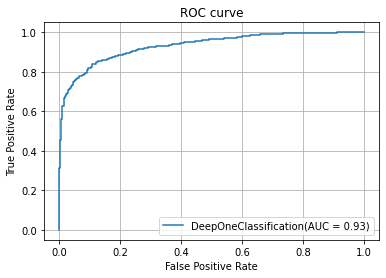

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

train = model.predict(X_train_s)
test_s = model.predict(X_test_s)
test_b = model.predict(X_test_b)

train = train.reshape((len(X_train_s),-1))
test_s = test_s.reshape((len(X_test_s),-1))
test_b = test_b.reshape((len(X_test_b),-1))

#Convert to 0-1
ms = MinMaxScaler()
train = ms.fit_transform(train)
test_s = ms.transform(test_s)
test_b = ms.transform(test_b)

# fit the model
clf = LocalOutlierFactor(n_neighbors=5)
y_pred = clf.fit(train)

#Abnormal score
Z1 = -clf._decision_function(test_s)
Z2 = -clf._decision_function(test_b)

#Drawing of ROC curve
y_true = np.zeros(len(test_s)+len(test_b))
y_true[len(test_s):] = 1 #0:Normal, 1：Abnormal

#Calculate FPR, TPR(, Threshould)
fpr, tpr, _ = metrics.roc_curve(y_true, np.hstack((Z1, Z2)))

#AUC
auc = metrics.auc(fpr, tpr)

#Plot the ROC curve
plt.plot(fpr, tpr, label='DeepOneClassification(AUC = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

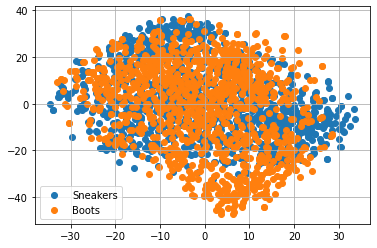

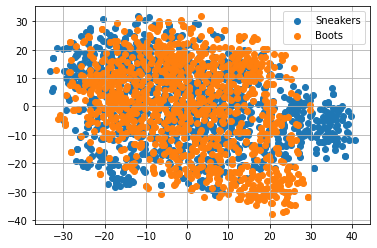

In [83]:
from sklearn.manifold import TSNE




new_mobile = tf.keras.applications.MobileNetV2(include_top=True, input_shape=(size, size, 3), alpha=alpha, weights='imagenet')

untrained_test_s = new_mobile.predict(X_test_s)
untrained_test_b = new_mobile.predict(X_test_b)

untrained_test_s_embedded = TSNE(n_components=2).fit_transform(test_s)
untrained_test_b_embedded = TSNE(n_components=2).fit_transform(test_b)

plt.figure()
plt.scatter(untrained_test_s_embedded[:, 0],untrained_test_s_embedded[:,1], label="Sneakers")
plt.scatter(untrained_test_b_embedded[:, 0],untrained_test_b_embedded[:,1], label="Boots")
plt.legend()
plt.grid(True)
plt.show()


test_s_embedded = TSNE(n_components=2).fit_transform(test_s)
test_b_embedded = TSNE(n_components=2).fit_transform(test_b)

plt.figure()
plt.scatter(test_s_embedded[:, 0],test_s_embedded[:,1], label="Sneakers")
plt.scatter(test_b_embedded[:, 0],test_b_embedded[:,1], label="Boots")
plt.legend()
plt.grid(True)
plt.show()
